# Calculate the mean transport distance for each country for internal transport

I used geopandas to calculate the centroid of each country and the border of each country.

Then I created a function to calculate the mean distance from centroid coordinates to a set of randomly generated points along the border of the country.

I used this mean distance as a proxy of intra-country transport distance.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, box
from geopy.distance import great_circle

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world['name'] == 'United States of America']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [24]:
def calculate_country_mean_transport_distance(country_name, number_points):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    country = world[world['name'] == country_name]
    center = country.geometry.centroid
    borders = country.geometry.boundary
    longitude = center.x.values[0]
    latitude = center.y.values[0]

        # Ensure we're working with a MultiLineString (handles single polygons)
    if isinstance(borders.iloc[0], LineString):
        borders = gpd.GeoSeries([borders.iloc[0]])

    # Sample random distances along the border
    total_length = borders.length.sum()
    random_distances = np.random.uniform(0, total_length, number_points)  # 1000 random points

    # Find points at those random distances
    sample_points = []
    current_distance = 0  # Track distance along the border
    for line in borders:
        for dist in random_distances:
            if current_distance <= dist < current_distance + line.length:
                # Interpolate the point if it falls within this line segment
                point = line.interpolate(dist - current_distance)
                sample_points.append(point)
        current_distance += line.length

        
    # Get the centroid coordinates correctly
    centroid_point = center.iloc[0]  # Extract the Point object
    centroid_coordinates = (centroid_point.y, centroid_point.x)

    # Create a bounding box for valid latitude range
    valid_latitude_box = box(-180, -90, 180, 90)

    # Clip the sample points to the valid latitude range
    clipped_sample_points = []
    for point in sample_points:
        if valid_latitude_box.contains(point):
            clipped_sample_points.append(point)
        else:
            # Clip the point to the nearest valid latitude
            x, y = point.x, max(-90, min(90, point.y))  
            clipped_sample_points.append(Point(x, y))

    # Calculate total distance and mean distance (using clipped_sample_points)
    total_distance = 0
    for coord in clipped_sample_points:
        total_distance += great_circle(centroid_coordinates, (coord.y, coord.x)).kilometers

    mean_distance = total_distance / len(clipped_sample_points) 

    print(f"Mean distance from centroid to {number_points} random points: {mean_distance:.2f} km")

    # Plotting (use clipped_sample_points to create the GeoDataFrame)
    fig, ax = plt.subplots(1, 1) 
    borders.plot(ax=ax, color='blue')  
    sample_gdf = gpd.GeoDataFrame(geometry=clipped_sample_points)
    sample_gdf.plot(ax=ax, color='red', markersize=50)
    centroid_gdf = gpd.GeoDataFrame(geometry=[center.iloc[0]])
    centroid_gdf.plot(ax=ax, color='green', marker='x', markersize=100)  
    ax.set_title(f"{country_name}'s Border with {number_points} Random Sample Points and Centroid (Clipped)")
    plt.show()

Mean distance from centroid to 1000 random points: 1813.95 km


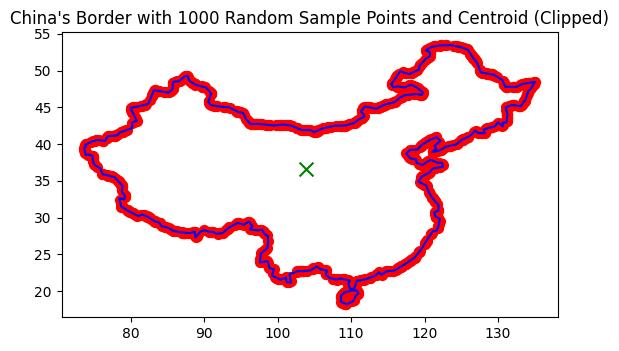

In [25]:
calculate_country_mean_transport_distance('China', 1000)

# Check dispersed countries

In [26]:
countries_with_dispersed_territories = [
    "Russia",
    "China",
#    "Netherlands",
    "France",
    "United Kingdom",
#    "Spain",
    "Portugal",
    "United States of America",
#    "Netherlands",
#    "Italy",
#    "Chile",
#    "Venezuela",
#    "Yemen"
]

Mean distance from centroid to 100 random points: 2527.51 km


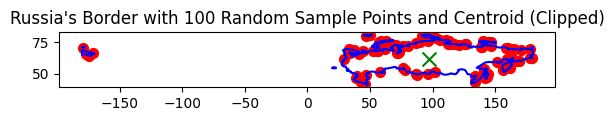

Mean distance from centroid to 100 random points: 1815.19 km


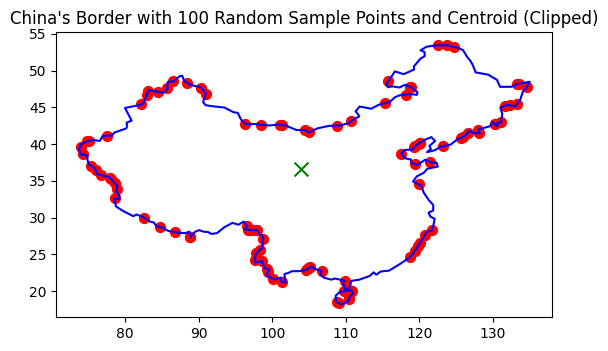

Mean distance from centroid to 100 random points: 1571.48 km


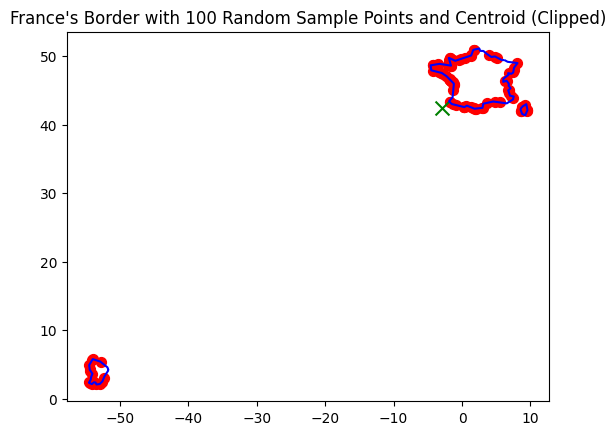

Mean distance from centroid to 100 random points: 322.92 km


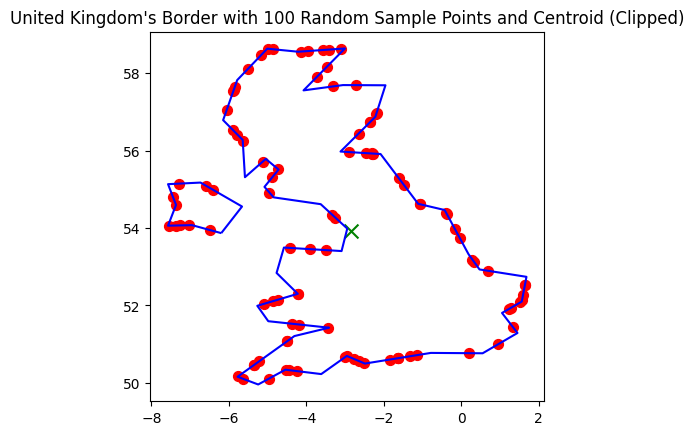

Mean distance from centroid to 100 random points: 195.60 km


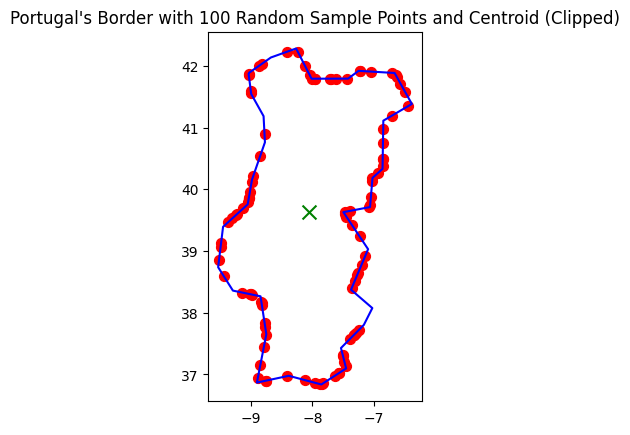

Mean distance from centroid to 100 random points: 2702.04 km


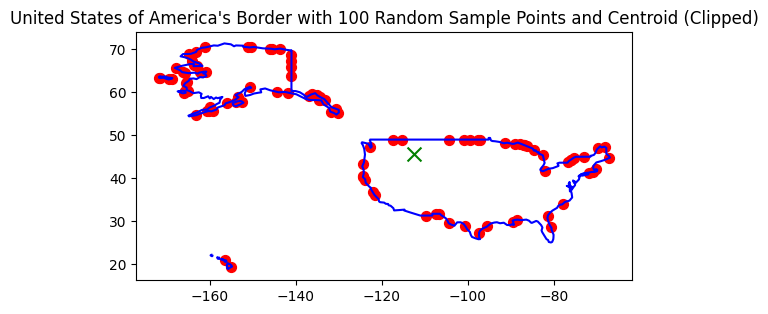

In [27]:
for country in countries_with_dispersed_territories:
    calculate_country_mean_transport_distance(country, 100)

# Add data to distance matrix

** Function modified with error handling and to return distance value **

In [28]:
def calculate_country_mean_transport_distance(country_name, number_points):
    try:
        country_name = country_name.title()
        # Data Loading
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
        
        # Country Selection and Geometry
        if country_name not in world['name'].values:
            raise ValueError(f"Country '{country_name}' not found in dataset.")
        country = world[world['name'] == country_name]
        center = country.geometry.centroid
        borders = country.geometry.boundary

        # Coordinate Extraction
        longitude = center.x.values[0]
        latitude = center.y.values[0]

        # Border Handling (Ensure MultiLineString)
        if isinstance(borders.iloc[0], LineString):
            borders = gpd.GeoSeries([borders.iloc[0]])

        # Random Distance Sampling Along Border
        total_length = borders.length.sum()
        random_distances = np.random.uniform(0, total_length, number_points)

        # Point Sampling and Interpolation
        sample_points = []
        current_distance = 0
        for line in borders:
            for dist in random_distances:
                if current_distance <= dist < current_distance + line.length:
                    point = line.interpolate(dist - current_distance)
                    sample_points.append(point)
            current_distance += line.length

        # Centroid Handling
        centroid_point = center.iloc[0]
        centroid_coordinates = (centroid_point.y, centroid_point.x)

        # Bounding Box for Valid Latitude
        valid_latitude_box = box(-180, -90, 180, 90)

        # Clipping to Valid Latitude Range
        clipped_sample_points = [
            point if valid_latitude_box.contains(point) else Point(point.x, max(-90, min(90, point.y)))
            for point in sample_points
        ]

        # Total and Mean Distance Calculation
        total_distance = sum(
            great_circle(centroid_coordinates, (coord.y, coord.x)).kilometers 
            for coord in clipped_sample_points
        )
        
        # Handling the case where there are no valid sample points.
        if len(clipped_sample_points) == 0:
            raise ValueError(f"No valid sample points found for '{country_name}'.")

        mean_distance = total_distance / len(clipped_sample_points)
        return mean_distance

    # Generalized Error Handling
    except Exception as e: 
        print(f"An error occurred: {e}")
        return 0  # Return 0 to indicate an error

Directly add data to trade matrix takes a lot of time. I will do this with distance_df

In [29]:
distance_df = pd.read_csv(r"..\data\FAOSTAT\clean_data\food_trading\country_matrix_v3.csv")
distance_df.head()

,country_from,continent_from,country_to,Continent_to,distance_in_km,same_continent,share_border,any_island_or_missing,transportation_method,country_from_code,country_to_code
0,afghanistan,asia,afghanistan,asia,0.000000,1,1.0,0,land,2,2
1,afghanistan,asia,albania,europe,4335.926901,0,0.0,0,water,2,3
2,afghanistan,asia,algeria,africa,5855.362822,0,0.0,0,water,2,4
3,afghanistan,asia,andorra,europe,5796.993207,0,NaN,1,water,2,-1
4,afghanistan,asia,angola,africa,7596.963990,0,0.0,0,water,2,7


In [30]:
distance_df['internal_distance'] = distance_df.apply(
    lambda row: calculate_country_mean_transport_distance(row['country_from'], 1000) if row['distance_in_km'] == 0 else np.nan,
    axis=1
)

An error occurred: Country 'Andorra' not found in dataset.
An error occurred: Country 'Antigua And Barbuda' not found in dataset.
An error occurred: Country 'Bahrain' not found in dataset.
An error occurred: Country 'Barbados' not found in dataset.
An error occurred: Country 'Bosnia And Herz.' not found in dataset.
An error occurred: Country 'Cape Verde' not found in dataset.
An error occurred: Country 'Cape Verde' not found in dataset.
An error occurred: Country 'Comoros' not found in dataset.
An error occurred: Country 'Cook Islands' not found in dataset.
An error occurred: Country 'Dominica' not found in dataset.
An error occurred: Country 'Eswatini' not found in dataset.
An error occurred: Country 'Grenada' not found in dataset.
An error occurred: Country 'Côte D'Ivoire' not found in dataset.
An error occurred: Country 'Kiribati' not found in dataset.
An error occurred: Country 'Liechtenstein' not found in dataset.
An error occurred: Country 'Maldives' not found in dataset.
An erro

In [33]:
distance_df2 = distance_df.copy()

In [34]:
distance_df2.shape

(54756, 12)

In [37]:
distance_df2.isnull().sum()

country_from                 0
continent_from               0
country_to                   0
Continent_to                 0
distance_in_km               0
same_continent               0
share_border             22660
any_island_or_missing        0
transportation_method        0
country_from_code            0
country_to_code              0
internal_distance        54494
dtype: int64

In [36]:
# remove rows full of nulls
distance_df2.dropna(inplace=True, axis=0, how='all')

In [58]:
distance_df2[distance_df2['share_border'].isnull()].sample(5) #If share_border is null, country does not exist in Geopandas. I will drop all of them

,country_from,continent_from,country_to,Continent_to,distance_in_km,same_continent,share_border,any_island_or_missing,transportation_method,country_from_code,country_to_code,internal_distance
47252,uruguay,south america,heard and mcdonald islands,antarctica,9093.589070,0,NaN,1,water,234,92,NaN
28745,micronesia (federated states of),oceania,united arab emirates,asia,11066.147188,0,NaN,1,water,145,225,NaN
37034,saint vincent and the grenadines,north america,estonia,europe,8523.969418,0,NaN,1,water,191,63,NaN
13468,ecuador,south america,nauru,oceania,12737.438791,0,NaN,1,water,58,148,NaN
52491,puerto rico,north america,grenada,north america,852.122486,1,NaN,1,water,177,86,NaN


In [44]:
# filter non-existent countries
distance_df2.dropna(subset='share_border', inplace=True)
distance_df2 = distance_df2[(distance_df2['country_from_code'] > 0) & (distance_df2['country_to_code'] > 0)]

# Russia, France and United States of America cases

I aproximate travel distance taking country surface and the radius of a circle of that surface.

Radius = sqrt(surface/pi)

In [64]:
surf_russia = 17098246 #km2
surf_france = 643801 #km2
surf_usa = 9826675
surf_argentina = 2780400 #km2 -----> to compare with function

In [65]:
for country, surface in [('Russia', surf_russia), ('France', surf_france), ('Argentina', surf_argentina), ('United States of America', surf_usa)]:
    radius = np.sqrt(surface/np.pi)
    print(f"Radius of {country}: {radius}")

Radius of Russia: 2332.9253606153916
Radius of France: 452.6899855696066
Radius of Argentina: 940.7596970243844
Radius of United States of America: 1768.5948662186886


In [66]:
dist_russia = 2332.9253606153916
dist_france = 452.6899855696066
dist_usa = 1768.5948662186886

In [67]:
special_cases = [('russia', dist_russia), ('france', dist_france), ('united states of america', dist_usa)]

for country, distance in special_cases:
    distance_df2['internal_distance'] = np.where((distance_df2['country_from'] == country) & 
                                                (distance_df2['country_to'] == country), distance,
                                                 distance_df2['internal_distance'])
                                                

In [72]:
country = 'united states of america' #to check it worked

distance_df2[(distance_df2['country_from'] == country) & (distance_df2['country_to'] == country)]

,country_from,continent_from,country_to,Continent_to,distance_in_km,same_continent,share_border,any_island_or_missing,transportation_method,country_from_code,country_to_code,internal_distance
46964,united states of america,north america,united states of america,north america,1768.594866,1,1.0,0,land,231,231,1768.594866
46965,united states of america,north america,united states of america,north america,1768.594866,1,1.0,0,land,231,232,1768.594866
46966,united states of america,north america,united states of america,north america,1768.594866,1,1.0,0,land,232,231,1768.594866
46967,united states of america,north america,united states of america,north america,1768.594866,1,1.0,0,land,232,232,1768.594866


In [71]:
distance_df2['distance_in_km'] = np.where((distance_df2['distance_in_km'] == 0), distance_df2['internal_distance'], distance_df2['distance_in_km'])

In [73]:
distance_df2.to_csv(r"..\data\FAOSTAT\clean_data\food_trading\country_matrix_v4_final.csv", index=False)